In [1]:
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

\begin{equation}
    \partial_t \mathbf{v} = \mu \nabla^2 \mathbf{v} - \nabla P + \alpha \nabla \cdot  \overleftrightarrow{m}
    \label{eq:stokes}
\end{equation}

\begin{equation}
    \partial_t c + (\mathbf{v} \cdot \nabla) c = 0
    \label{eq:cadherinadvection}
\end{equation}

\begin{equation}
    \partial_t m_{ij} + (\mathbf{v} \cdot \nabla) m_{ij} + [\Omega, m]_{ij} = 
    -\frac{1}{\tau} (1 - \delta_c c) m_{ij} + 
    k_E (1 + \alpha_c c) m_{ij} E_{kk} + 
    k_m (1 - \beta_c c) m_{ij} m_{kk} + 
    k_{\Gamma} (1 - \gamma_c) \Gamma_{ij}^{DV} m_{kk}
    \label{eq:myosinmodel}
\end{equation}

We have roughly that \tau  = 15, k_E = 0.5, k_m = 0.5, and k_{\Gamma} = 0.05. \alpha, \beta, and \gamma are all approx 0.8. You are correct that the \gamma_c term should be multiplied by c. I’ve realized that Equation (6) in the text is not quite up to date: the detachment is also cadherin-modulated in the latest version of the code. It should look something like below, with \delta~0.8

In [4]:
def plot(ax, mij, vi, c, x, y, mmin=None, mmax=None, vmax=None, skip=5):    
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    
    pcM = ax[0].pcolormesh(x, y, m.T, cmap='inferno', vmin=mmin, vmax=mmax)

    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    ax[0].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                 pivot='middle', color='white',
                 headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[0])
    cb.ax.set_title("|m|")
    ax[0].set_title(r'$m_{ij}$')

    pcV = ax[1].pcolormesh(x, y, np.linalg.norm(vi, axis=0).T, vmin=0, vmax=vmax, cmap='YlOrRd')
    ax[1].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, 
                 color="black")
    cb = plt.colorbar(pcV, ax=ax[1])
    cb.ax.set_title("|v|")
    ax[1].set_title(r'$\mathbf{v}$')
    
    vort = np.gradient(vi[1], x, axis=-2) - np.gradient(vi[1], y, axis=-1)
    wmax = max(abs(np.min(vort)), np.max(vort))
    pcW = ax[2].pcolormesh(x, y, vort.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
    cb = plt.colorbar(pcW, ax=ax[2])
    cb.ax.set_title('Vorticity')
    ax[2].set_title('$\\omega$')
    
    pcC = ax[3].pcolormesh(x, y, c.T, cmap='viridis')
    cb = plt.colorbar(pcC, ax=ax[3])
    cb.ax.set_title('c')
    ax[3].set_title('$c$')

    for a in ax:
        a.set(xlabel='AP', ylabel='DV', 
              xticks=[], yticks=[], 
              aspect='equal')
        
def plot_trajectories(ax, mij, vi, c, t):
    ax[0].plot(t, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)))
    ax[1].plot(t[1:], np.mean(np.linalg.norm(vi[1:], axis=(1)), axis=(1, 2)))
    ax[3].plot(t, np.mean(c, axis=(1, 2)))
    
    ax[0].set(xlabel='Time', ylabel=r"$\langle|\!|m|\!|\rangle_{{\rm space}}$")
    ax[1].set(xlabel='Time', ylabel=r"$\langle|\!|v|\!|\rangle_{{\rm space}}$")
    ax[3].set(xlabel='Time', ylabel=r"$\langle|c|\rangle_{{\rm space}}$")
    
    ax[2].axis('off')
    
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 6

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def plot_all(mij, vi, c, t0, x, y, mmin=None, mmax=None, vmax=None, skip=5, half=False):
    if half:
        fig, ax = plt.subplots(5, 3, dpi=200, figsize=(6, 5.5))
    else:
        fig, ax = plt.subplots(5, 3, dpi=200, figsize=(6, 10))

    ax[-1, 0].plot(t0, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)), 
                   color='firebrick', label=r"$\langle|\!|m|\!|\rangle_{{\rm space}}$")    
    ax[-1, 1].plot(t0[1:], np.mean(np.linalg.norm(vi[1:], axis=(1)), axis=(1, 2)),
                   color='black', label=r"$\langle|\!|v|\!|\rangle_{{\rm space}}$")
    ax[-1, 2].plot(t, np.mean(c, axis=(1, 2)),
                   color='steelblue', label=r"$\langle|c|\rangle_{{\rm space}}$")
    for a in ax[-1]:
        a.set_xlabel('Time')
        a.tick_params(which='both', direction='in')
        a.legend(framealpha=False)
    

    m0, m1 = mij[1], mij[-1]
    v0, v1 = vi[1],  vi[-1]
    c0, c1 = c[1],   c[-1]
    w0 = np.gradient(v0[1], x, axis=-2) - np.gradient(v0[1], y, axis=-1)
    w1 = np.gradient(v1[1], x, axis=-2) - np.gradient(v1[1], y, axis=-1)
    wmax = max(max(abs(np.min(w0)), np.max(w0)), max(abs(np.min(w1)), np.max(w1)))
        
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    for i, (mi, v, w, ci) in enumerate([(m0, v0, w0, c0), (m1, v1, w1, c1)]):
        m, n = get_director_magnitude(mi)
        pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=mmin, vmax=mmax)
        ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
        
        pcV = ax[1, i].pcolormesh(x, y, np.linalg.norm(v, axis=0).T, vmin=0, vmax=vmax, cmap='YlOrRd')
        ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, color="black")
        pcW = ax[2, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
        
        pcC = ax[3, i].pcolormesh(x, y, ci.T, cmap='viridis')
        
    cb = plt.colorbar(pcM, ax=ax[0, i])
    cb.ax.set_title("|m|")
        
    cb = plt.colorbar(pcV, ax=ax[1, i])
    cb.ax.set_title("|v|")
    
    cb = plt.colorbar(pcW, ax=ax[2, i])
    cb.ax.set_title('$\\omega$')
    
    cb = plt.colorbar(pcC, ax=ax[3, i])
    cb.ax.set_title('c')
    
    pcM = ax[0, -1].pcolormesh(x, y, m.T, cmap='inferno')
    ax[0, -1].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
    cb = plt.colorbar(pcM, ax=ax[0, -1])
    cb.ax.set_title("|m|")
        
    pcV = ax[1, -1].pcolormesh(x, y, np.linalg.norm(v, axis=0).T, cmap='YlOrRd')
    ax[1, -1].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, color="black")
    cb = plt.colorbar(pcV, ax=ax[1, -1])
    cb.ax.set_title("|v|")
    
    pcW = ax[2, -1].pcolormesh(x, y, w.T, cmap='PiYG')
    cb = plt.colorbar(pcW, ax=ax[2, -1])
    cb.ax.set_title("$\\omega$")
    
    pcC = ax[3, -1].pcolormesh(x, y, ci.T, cmap='viridis')
    cb = plt.colorbar(pcC, ax=ax[3, -1])
    cb.ax.set_title("$c$")

    for a in ax[:-1].flatten():
        a.set(xticks=[], yticks=[], aspect='equal')
        if half:
            a.set_ylim([a.get_ylim()[0], 0])
    ax[0, 0].set_title('Initial condition')
    ax[0, 1].set_title('Final condition')
    ax[0, 2].set_title('Final (color unnormalized)')
        
    fig.subplots_adjust(wspace=0.02)

In [43]:
def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def simu(params, set_initial_conditions, logger):
    # params: dict containing all parameters
    # initial_conditions: function (dist, (xbasis, ybasis), c, v, m) -> None that should modify the [d3.Field]s c,v,m
    # logger: logging.Logger
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    mu = params["mu"]
    α  = params["α"]
    τ  = params.get("τ", 1e5)
    A  = params.get("A", 0)
    B  = params.get("B", 0)
    C  = params.get("C", 0)
    D  = params.get("D", 0)
    km = params.get("km", 0)
    kE = params.get("kE", 0)

    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis,ybasis))
    tau_p = dist.Field(name='tau_p')
    tau_v = dist.VectorField(coords, name='tau_u')

    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2

    #Static velocity Problem
    problem = d3.IVP([c, m, v, p, tau_p, tau_v], namespace=locals())
    problem.add_equation("dt(c) = - v@grad(c)") #Cadherin advection
    problem.add_equation("grad(p) - mu*lap(v) - α * div(m) + tau_v = 0") # Stokes equation (with velocity tau term)
    problem.add_equation("div(v) + tau_p = 0")  #Pressure tau term for stokes equation
    problem.add_equation("integ(p) = 0")        #Fix pressure gauge
    problem.add_equation("integ(v) = 0")        #Fix velocity gauge
    problem.add_equation(params['m_eq'])
    
    # Solver
    solver = problem.build_solver(d3.SBDF2)
    solver.stop_sim_time = params['max_time']

    # Initial conditions
    set_initial_conditions(dist=dist, bases=(xbasis, ybasis), params=params, c=c, v=v, m=m)
    
    # Main loop
    save_every = params["save_every"]
    t_list, c_list, m_list, v_list = [], [], [], []
    try:
        logger.info("Starting main loop")
        while solver.proceed:
            if solver.iteration % save_every == 0:
                t_list.append(solver.sim_time)
                c_list.append(get_g_with_scales(c, (1,1)))
                m_list.append(get_g_with_scales(m, (1,1)))
                v_list.append(get_g_with_scales(v, (1,1)))
            solver.step(params['timestep'])
            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                raise Exception("computation diverges: adjust dt and/or dx")
                solver.stop_iteration = 0
            if (solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time}, dt={params['timestep']}")
    except:
        logger.error("Exception raised, triggering end of main loop.")
        raise
        
    return {"params": params, 
            "fields": {"c":c, "v": v, "m": m}, 
            "bases": (xbasis, ybasis),
            "trajectory": {"c": c_list, "v": v_list, "m": m_list, "t": t_list}}


def ics(dist, bases, params, c, v, m):
    xbasis, ybasis = bases
    x, y = dist.local_grids(xbasis, ybasis)
    Lx, Ly = params['Lx'], params['Ly']
    if params['m_ic'] is None:
        x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
        y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
        m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[3].T)(x, y)
        m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[1].T)(x, y)
        m["g"][1,0,:,:] = m['g'][0,1,:,:]
        m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[0].T)(x, y)
    else:
        m['g'] = params['m_ic']
        
    if params['c_ic'] is None:
        x0 = np.linspace(-Lx/2, Lx/2, c0.shape[-1])
        y0 = np.linspace(-Ly/2, Ly/2, c0.shape[-2])
        c['g'][:] = RectBivariateSpline(x0, y0, c0.T)(x, y)
    else:
        c["g"] = 0.8 + 0.2 * (1 + np.cos(2*np.pi*y/Ly))*(1+np.cos(2*np.pi*x/Lx))
    
    print(c['g'].max(), c['g'].min())
    v["g"][:] = 0

## Summary of myosin-only cases

1. Passive advection $D_t m_{ij} = \partial_t m_{ij} + \mathbf{v} \cdot \nabla m_{ij} + \left( \Omega_{ik} m_{kj} - m_{ik} \Omega_{kj} \right) = 0$
    - Fixed point for any $m_{ij} = $ constant. 
    - For a given anisotropy direction $\theta$, 
        - Stable to pertubrations parallel to $\theta$
        - Unstable to perturbations perpendicular to $\theta$
2.  Linear dynamics $D_t m_{ij} = \pm \frac{1}{\tau} m_{ij} $
    - Fixed points at $m_{ij} = 0$
        - Stable for $\tau \lt 0$ (Simulate with $\{\tau = 50\}$)
        - Unstable for $\tau \gt 0$ (Simulate with $\{\tau = -50\}$)
3. Quadratic dynamics $D_t m_{ij} = \pm \frac{1}{\tau} m_{ij} \pm A m_{ij} m_{kk}$
    - Fixed point at $m_{ij} = 0$
        - Stable for $\tau \lt 0$, unstable for $\tau \gt 0$
    - Fixed point at $m_{kk} = -1/A\tau$ (iff $A\tau < 0$)
        - Unstable for $A > 0, \tau < 0$ (Simulate with $\{\tau = -20, A = 0.4\}$)
        - Stable for $A < 0, \tau > 0$ (Simulate with $\{\tau = 20, A = -0.4\}$)
4.  Cubic dynamics $D_t m_{ij} = \pm \frac{1}{\tau} m_{ij} \pm B m_{ij} m_{kk}^2 $
    - Fixed point at $m_{ij} = 0$
        - Stable for $\tau \lt 0$, unstable for $\tau \gt 0$
    - Fixed point at $m_{kk} = \sqrt{-1/B\tau}$ (iff $A\tau < 0$)
        - Unstable for $B > 0, \tau < 0$ (Simulate with $\{\tau = -20, B = 3.2\}$)
        - Stable for $B < 0, \tau > 0$ (Simulate with $\{\tau = 20, B = -3.2\}$)
5.  Linear Diffusion $D_t m_{ij} = \pm \frac{1}{\tau} m_{ij} + D \nabla^2 m_{ij}$
    - Fixed points at $m_{ij} = 0$
        - Stable to short-wavelength pertubations $q^2 > 1/D\tau$ (Simulate with $\{\tau = 20, D=[10, 10^2, 10^3, 10^4] \}$)
        - Unstable to long-wavelength perturbations $q^2 < 1/D\tau$
        - TODO: plot time-dependent power-spectrum
6.  Mechanical feedback $D_t m_{ij} = \pm \frac{1}{\tau} m_{ij} + C \left( m_{ik} E_{kj} + E_{ik} m_{kj} \right) $

7.  Quadratic Diffusion $D_t m_{ij} = \pm \frac{1}{\tau} m_{ij} +  A m_{ij} m_{kk} + D \nabla^2 m_{ij}$
    - Fixed point at $m_{ij} = 0$
        - $\tau < 0$ - Stable
        - $\tau > 0$ - Unstable to long-wavelength perturbations as in (5)
    - Fixed point at $m_{kk} = -1/A\tau$ (iff $A\tau < 0$)
        - $A > 0, \tau < 0$  Simulate with $\{\tau = -20, A = 1\} \rightarrow m_{kk}^0 = 0.05$
            - Unstable to long-wavelength perturbations both isotropic and with $q \perp m_0$
            - **With $D=10^2$, this is the first candidate for forming patterns**, however, the instability eventually blows up
        - $A < 0, \tau > 0$  Simulate with $\{\tau = 20, A = -1\} \rightarrow m_{kk}^0 = 0.05$
            - Unstable to long-wavelength perturbations with $q \perp m_0$ (Simulate with $D=[0.1, 1, 10, 10^2]$)
            - Stable to perturbations with $q \parallel m_0$
8.  Cubic Diffusion $D_t m_{ij} =  m_{ij} \left( \frac{1}{\tau} m_{ij} + A m_{kk} + B m_{kk}^2 \right) D \nabla^2 m_{ij}$
    - Fixed point at $m_{ij} = 0$
    - Fixed point at $m_{kk} = -\frac{A + \sqrt{A^2 - 4 B/\tau}}{2B}$ **iff $A/B < 0$**
    - Fixed point at $m_{kk} = -\frac{A - \sqrt{A^2 - 4 B/\tau}}{2B}$ **iff $A/B < 0$ AND $A^2 > 4B/\tau$**
    - Simulate with $\{ \tau = -20, A = 4/3, B=-20/3 \} \rightarrow m_{kk}^0 = 0.05, 0.15$
        - **Pattern-forming candidate with $D=10^2$ but the pattern is not stable and eventually vanishes over time**
        - **TODO** - plot myosin spectrum as a function of time
        - Does not produce plausible vortices unless the A-P asymmetry is eliminated
        
**Crucial point** - The initial condition in a real fly is not quite symmetric. A dynamical system which enables pattern-formation (unstable to perturbations at some wavelength) will never eliminate this asymmetry (at least on a periodic domain). It's worth checking this on a cylindrical domain, as well as a sphere.

Initial time = -10
1.6 0.8
2023-06-04 13:41:00,913 __main__ 0/1 INFO :: Starting main loop
2023-06-04 13:41:01,360 __main__ 0/1 INFO :: Iteration=1, Time=0.1, dt=0.1
2023-06-04 13:41:04,808 __main__ 0/1 INFO :: Iteration=101, Time=10.09999999999998, dt=0.1
2023-06-04 13:41:06,480 solvers 0/1 INFO :: Simulation stop time reached.


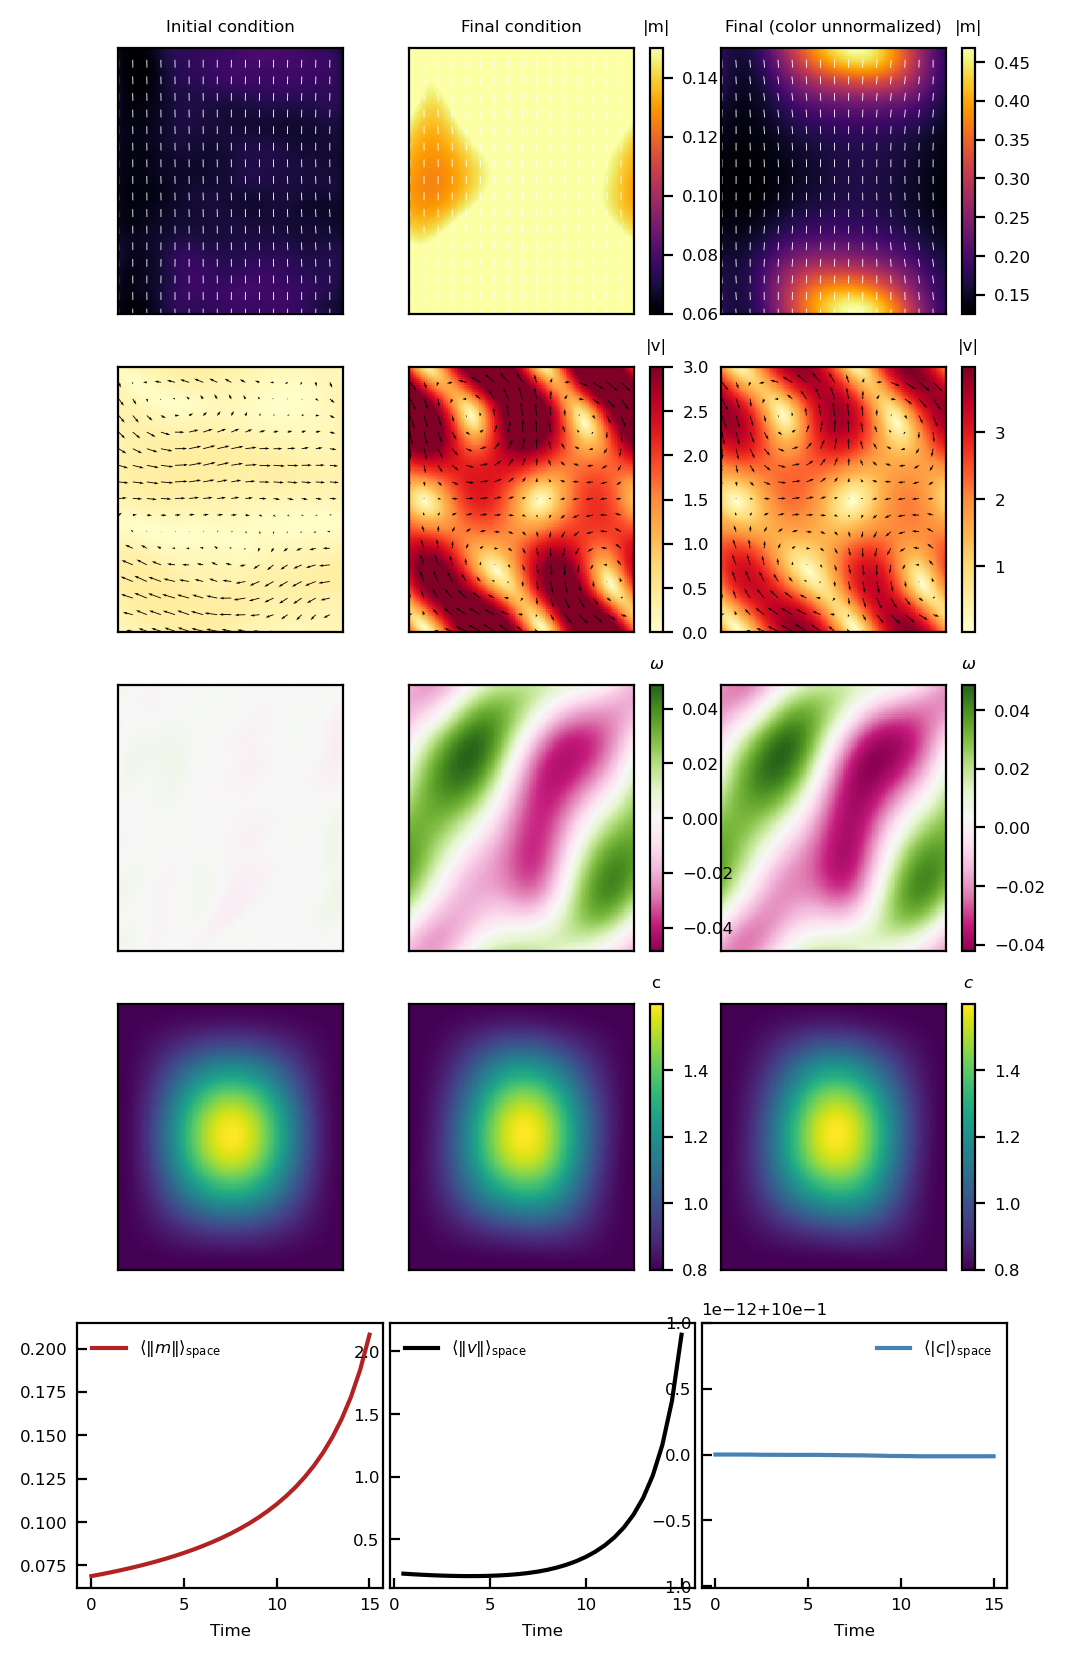

In [6]:
from scipy.interpolate import RectBivariateSpline
folder = '../for_michel/data'

tt = 0
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')

m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt, ..., 20:-20]

#folder = 'test_data'
#m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt]

params = dict(
    mu = 1., α = 3., 
    #τ = -20, A = 4/3, B = -20/3, C = 0, D = 1e0, k0=0,
    τ = -20, A = 1, B = 0, C = 0, D = 1e2, k0=0,
    m_ic=None,
    c_ic=True,
    Lx=452., Ly=533.,   #Units of microns
    Nx=128, Ny=128,     #Not equal to check transpose
    max_time=15, timestep=0.1, save_every=5,
    m_eq='dt(m) - D*lap(m) - 1/τ * m = - (Ω @ m - m @ Ω)  - v @ grad(m) + A*m*trace(m) + B * m * trace(m)**2 + C * (E @ m + m @ E)'
)
logging.getLogger('subsystems').setLevel('ERROR')
data = simu(params, ics, logger)
x = np.squeeze(data["bases"][0].local_grid())
y = np.squeeze(data["bases"][1].local_grid())

kwargs = dict(vmax=3, mmin=0.06, mmax=0.15, skip=8)
c, v, m, t = data["trajectory"]["c"], data["trajectory"]["v"], data["trajectory"]["m"], data['trajectory']['t']
plot_all(m, v, c, t, x, y, **kwargs, half=False)

## Summary of myosin-cadherin cases

1. $D_t m_{ij} = \frac{1}{\tau} (1 + k_0 c) m_{ij} + A m_{ij} m_{kk}$
    - Fixed point $m_{ij} = 0$
    - Fixed point $m_{kk} = -\frac{1}{\tau A} (1 + k_0 c)$

Initial time = -10
Fixed point at 0.3333333333333333
1.4786715070382301 0.8507279000455634
2023-06-04 15:19:28,894 __main__ 0/1 INFO :: Starting main loop
2023-06-04 15:19:28,945 __main__ 0/1 INFO :: Iteration=1, Time=0.1, dt=0.1
2023-06-04 15:19:29,947 __main__ 0/1 INFO :: Iteration=101, Time=10.09999999999998, dt=0.1
2023-06-04 15:19:30,921 __main__ 0/1 INFO :: Iteration=201, Time=20.100000000000016, dt=0.1
2023-06-04 15:19:31,883 solvers 0/1 INFO :: Simulation stop time reached.


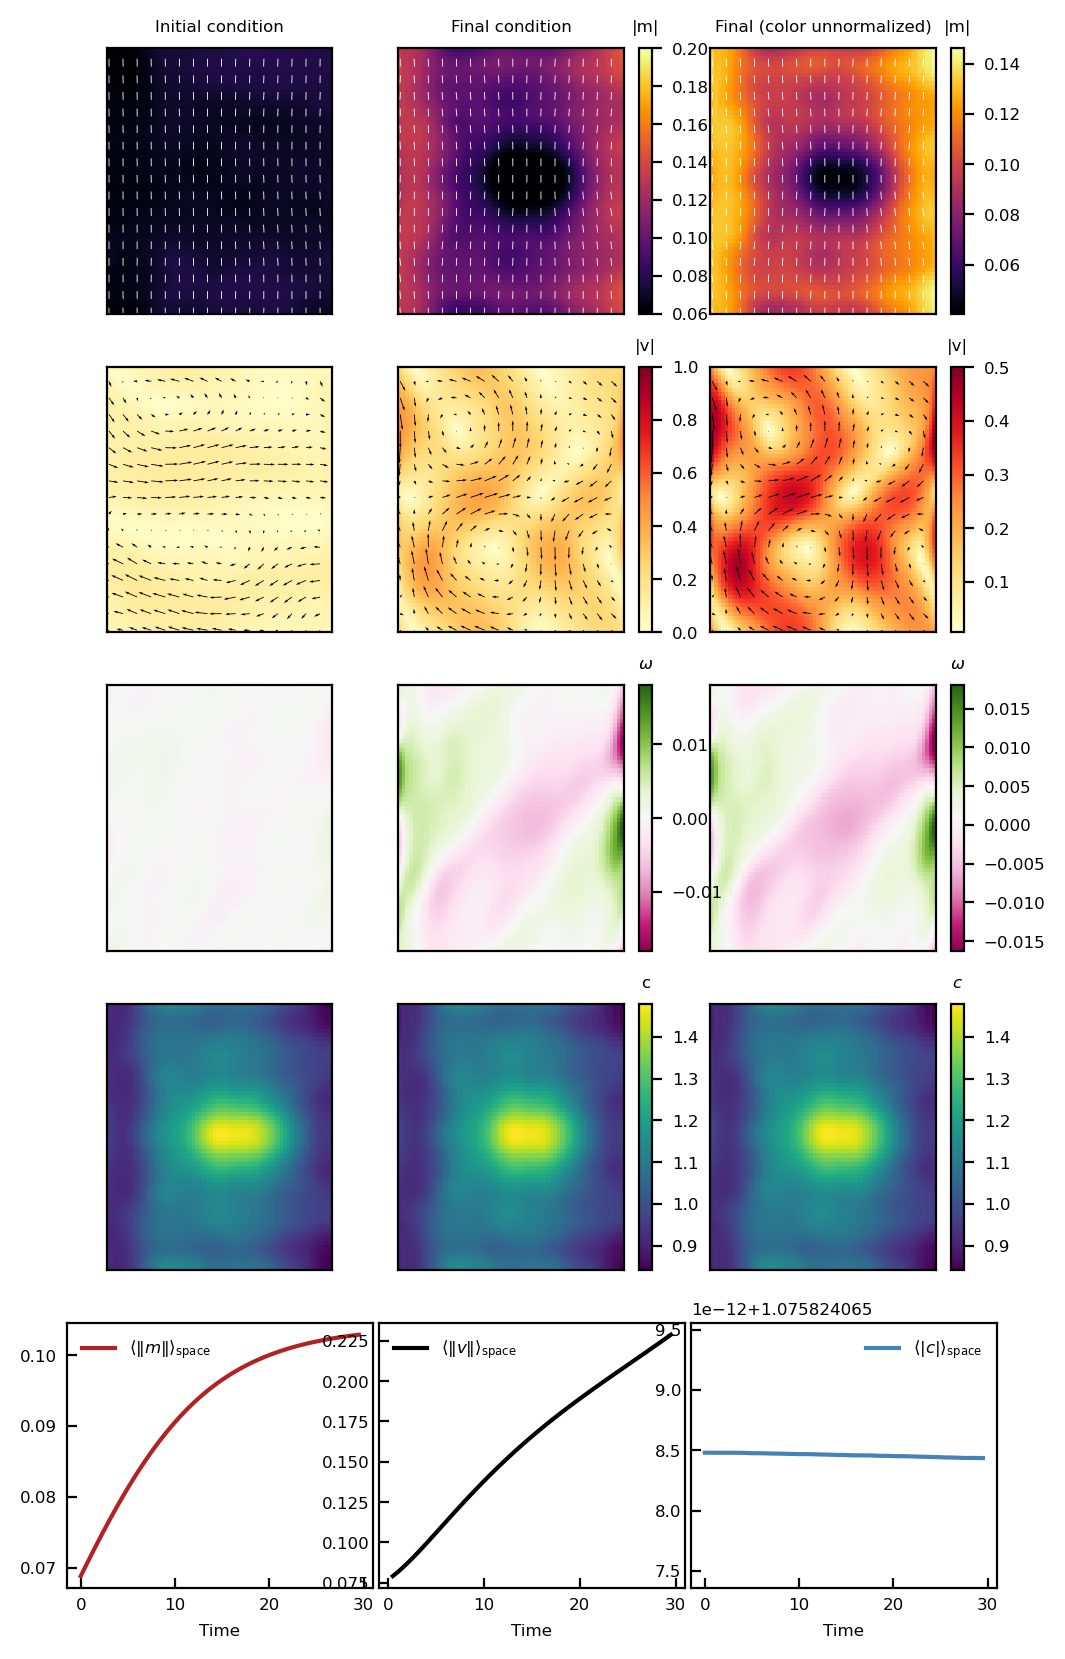

In [45]:
from scipy.interpolate import RectBivariateSpline
folder = '../for_michel/data'

tt = 0
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')

m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt, ..., 20:-20]
c0 = np.load(f'{folder}/cadherin.npy', mmap_mode='r')[tt, ..., 20:-20].squeeze()
params = dict(
    mu = 1., α = 1., 
    τ = 3, A = -1, C=0., #Base terms
    km=-0.6, kE=0.,     #Cadherin terms
    m_ic=None,
    c_ic=None,
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,     #Not equal to check transpose
    max_time=30, timestep=0.1, save_every=5,
    m_eq='dt(m) = - (Ω @ m - m @ Ω)  - v @ grad(m) + (1 + km * c) / τ * m + A*m*trace(m) + C * (1 + kE * c) * (E @ m + m @ E)'
)
'''
params = dict(
    mu = 1., α = 3., 
    τ = 3, A = -1, C=0.5, #Base terms
    km=-0.6, kE=0.25,     #Cadherin terms
    m_ic=None,
    c_ic=None,
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,     #Not equal to check transpose
    max_time=30, timestep=0.1, save_every=5,
    m_eq='dt(m) = - (Ω @ m - m @ Ω)  - v @ grad(m) + (1 + km * c) / τ * m + A*m*trace(m) + C * (1 + kE * c) * (E @ m + m @ E)'
)
'''
'''
params = dict(
    mu = 1., α = 3., 
    τ = 3, A = -1,   #Base terms
    km=-0.6, kE=0.65, #Cadherin terms
    m_ic=None,
    c_ic=None,
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,     #Not equal to check transpose
    max_time=30, timestep=0.1, save_every=5,
    m_eq='dt(m) = - (Ω @ m - m @ Ω)  - v @ grad(m) + (1 + km * c) / τ * m + A*m*trace(m) + kE * c * (E @ m + m @ E)'
)
'''
print(f'Fixed point at {-1/(params["A"]*params["τ"])}')

data = simu(params, ics, logger)
x = np.squeeze(data["bases"][0].local_grid())
y = np.squeeze(data["bases"][1].local_grid())

kwargs = dict(vmax=1, mmin=0.06, mmax=0.2, skip=4)
c, v, m, t = data["trajectory"]["c"], data["trajectory"]["v"], data["trajectory"]["m"], data['trajectory']['t']
plot_all(m, v, c, t, x, y, **kwargs, half=False)

# Saving data for external analysis

In [36]:
from scipy.interpolate import RectBivariateSpline
folder = '../for_michel/data'

tt = 0
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')

m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt, ..., 20:-20]
c0 = np.load(f'{folder}/cadherin.npy', mmap_mode='r')[tt, ..., 20:-20].squeeze()

def run_and_save(params, filename, logger):
    Lx, Ly = params["Lx"], params["Ly"]
    Nx, Ny = params["Nx"], params["Ny"]
    dealias = 3/2
    
    mu = params["mu"]
    α  = params["α"]
    τ  = params.get("τ", 1e5)
    A  = params.get("A", 0)
    B  = params.get("B", 0)
    C  = params.get("C", 0)
    D  = params.get("D", 0)
    km = params.get("km", 0)
    kE = params.get("kE", 0)

    # Bases
    coords = d3.CartesianCoordinates("x", "y")
    dist = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
    ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)
    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    c = dist.ScalarField(name='c', bases=(xbasis,ybasis))
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis, ybasis))
    p = dist.Field(name='p', bases=(xbasis,ybasis))
    
    #Fixing gauge conditions
    tau_p = dist.Field(name='tau_p')
    tau_v = dist.VectorField(coords, name='tau_u')

    #Substitutions
    Ω = (d3.grad(v) - d3.transpose(d3.grad(v))) / 2
    E = (d3.grad(v) + d3.transpose(d3.grad(v))) / 2

    #Static velocity Problem
    problem = d3.IVP([c, m, v, p, tau_p, tau_v], namespace=locals())
    problem.add_equation("grad(p) - mu*lap(v) - α * div(m) + tau_v = 0") # Stokes equation (with velocity tau term)
    problem.add_equation("div(v) + tau_p = 0")  #Pressure tau term for stokes equation
    problem.add_equation("integ(p) = 0")        #Fix pressure gauge
    problem.add_equation("integ(v) = 0")        #Fix velocity gauge
    
    #Protein fields
    problem.add_equation("dt(c) = - v@grad(c)") #Cadherin advection
    eq_m  = "dt(m) - D*lap(m) ="
    eq_m += " -(Ω @ m - m @ Ω)  - v @ grad(m)" #Advection
    eq_m += " + (1 + km * c) / τ * m" #Linear growth/decay
    eq_m += " + A*m*trace(m) + B * m * trace(m)**2" #Higher-order feedback for setting FPs
    eq_m += "  + C * (1 + kE * c) * (E @ m + m @ E)" #Mechanical feedback
    problem.add_equation(eq_m)

    #Myosin initial conditions
    x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
    y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[3].T)(x, y)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[1].T)(x, y)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[0].T)(x, y)

    #Cadherin initial conditions
    x0 = np.linspace(-Lx/2, Lx/2, c0.shape[-1])
    y0 = np.linspace(-Ly/2, Ly/2, c0.shape[-2])
    c['g'][:] = RectBivariateSpline(x0, y0, c0.T)(x, y)
    
    v["g"][:] = 0
    
    # Solver
    solver = problem.build_solver(d3.SBDF2)
    solver.stop_sim_time = params['max_time']
    analysis = solver.evaluator.add_file_handler(f'dedalus_runs/{filename}', 
                                                 iter=params['save_every'], 
                                                 mode='append')
    analysis.add_tasks(solver.state, layout='g')
    
    # Main loop
    try:
        logger.info("Starting main loop")
        while solver.proceed:
            solver.step(params['timestep'])
            if np.isnan(np.mean(v["g"])) or np.isnan(np.mean(m["g"])) or np.isnan(np.mean(c["g"])):
                logger.error("computation diverges: adjust dt and/or dx")
                raise Exception("computation diverges: adjust dt and/or dx")
            if (solver.iteration-1) % 100 == 0:
                logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time}")
    except:
        logger.error("Exception raised, triggering end of main loop.")
    finally:
        #Write parameters to file
        with analysis.get_file() as h5f:
            prms = h5f.create_group('params')
            for key in params:
                prms[key] = params[key]

Initial time = -10


In [52]:
base_params = dict(
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,     #Not equal to check transpose
    max_time=500, timestep=0.1, save_every=5,
)
cases = [
    #['Cadherin', dict(mu = 1., α = 1., τ = 3, A = -1, km=-0.6)],
    #['Cadherin', dict(mu = 1., α = 3., τ = 3, A = -1, C=0.5, km=-0.6, kE=0.25)], #Mechanical feedback
    ['Cadherin', dict(mu = 1., α = 1., τ = 3, A = -1, C=0.5, km=-0.6, kE=0.25)], #Mechanical feedback
]
for filename, params in cases:
    print(f'Running {filename}')
    params = {**base_params, **params}
    run_and_save(params, filename, logger)

Running Cadherin
2023-06-04 16:33:40,400 __main__ 0/1 INFO :: Starting main loop
2023-06-04 16:33:40,494 __main__ 0/1 INFO :: Iteration=1, Time=0.1
2023-06-04 16:33:41,784 __main__ 0/1 INFO :: Iteration=101, Time=10.09999999999998
2023-06-04 16:33:43,037 __main__ 0/1 INFO :: Iteration=201, Time=20.100000000000016
2023-06-04 16:33:44,291 __main__ 0/1 INFO :: Iteration=301, Time=30.100000000000158
2023-06-04 16:33:45,570 __main__ 0/1 INFO :: Iteration=401, Time=40.1000000000003
2023-06-04 16:33:46,829 __main__ 0/1 INFO :: Iteration=501, Time=50.10000000000044
2023-06-04 16:33:48,080 __main__ 0/1 INFO :: Iteration=601, Time=60.100000000000584
2023-06-04 16:33:49,360 __main__ 0/1 INFO :: Iteration=701, Time=70.10000000000029
2023-06-04 16:33:50,619 __main__ 0/1 INFO :: Iteration=801, Time=80.09999999999972
2023-06-04 16:33:51,873 __main__ 0/1 INFO :: Iteration=901, Time=90.09999999999916
2023-06-04 16:33:53,149 __main__ 0/1 INFO :: Iteration=1001, Time=100.09999999999859
2023-06-04 16:33:5

In [50]:
base_params = dict(
    mu = 1., α = 3., #Stokes terms, roughly correct units
    Lx=452., Ly=533.,   #Units of microns
    Nx=64, Ny=64,     #Not equal to check transpose
    max_time=100, timestep=0.1, save_every=5,
)

cases = [
    #['Passive', {}],
    #['Linear', dict(τ = +50)], #Growth
    #['Linear', dict(τ = -50)], #Decay
    #['Quadratic', dict(τ = -20, A = +0.4)], #FP > m0, unstable
    #['Quadratic', dict(τ = +20, A = -0.4)], #FP > m0, stable
    ['Quadratic', dict(τ = -20, A = +1.0)], #FP < m0, unstable
    #['Quadratic', dict(τ = +20, A = -1.0)], #FP > m0, stable
    #['Cubic', dict(τ = +20, B = -3.2)], #FP > m0, unstable
    #['Cubic', dict(τ = -20, B = +3.2)], #FP > m0, stable
]

for filename, params in cases:
    print(f'Running {filename}')
    params = {**base_params, **params}
    run_and_save(params, filename, logger)

Running Quadratic
2023-06-04 15:39:21,606 __main__ 0/1 INFO :: Starting main loop
2023-06-04 15:39:21,694 __main__ 0/1 INFO :: Iteration=1, Time=0.1
2023-06-04 15:39:22,814 __main__ 0/1 INFO :: Iteration=101, Time=10.09999999999998
2023-06-04 15:39:23,452 __main__ 0/1 ERROR :: computation diverges: adjust dt and/or dx
2023-06-04 15:39:23,453 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.


In [ ]:
D = [1e1, 1e2, 1e3, 1e4, 1e5]
cases = [
    ['Linear Diffusion', dict(τ = 20)],
    ['Quadratic Diffusion', dict(τ = -20, A = +1)], #Unstable FP < m0
    ['Quadratic Diffusion', dict(τ = +20, A = -1)], #Stable FP < m0
    ['Quadratic Diffusion', dict(τ = -20, A = +0.4)], #Unstable FP > m0
    ['Quadratic Diffusion', dict(τ = +20, A = -0.4)], #Stable FP > m0
    ['Cubic Diffusion', dict(τ = -20, A = 4/3, B=-20/3)]
]

for filename, params in cases:
    params = {**base_params, **params}
    for d in D:
        print(f'Running {filename}, D={d}')
        params['D'] = d
        run_and_save(params, filename, logger)